# Downstream visualizations using haplotypes

Imports.

In [1]:
import re # string search

import adjustText # prevent overlapping text
import matplotlib.pyplot as plt # make simple visualizations
import numpy as np # data management
import pandas as pd # data management
import sklearn # PCA

# these classes must be imported specially
from sklearn.decomposition import PCA
from matplotlib.figure import SubFigure

import genotype_helpers # genotype processing
import io_helpers # file I/O

print(f'''
This notebook adds:
adjustText version {adjustText.__version__}, 
scikit-learn version {sklearn.__version__}
''')


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This genotype helper file adds:
NumPy version 1.24.3,
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6


This notebook adds:
adjustText version 0.8, 
scikit-learn version 1.2.2



Constants.

In [2]:
sample_info = io_helpers.load_sample_info_and_haplogroups(add_female_to_y=False)
# extract numeric YYYY from YYYY-MM-DD string (int can't handle np.nan)
sample_info['yob'] = sample_info['dob'].str.slice(stop=4).astype(float)
seq_methods = ['lcWGS', 'ddGBS']

tissue_names = io_helpers.read_csv('data', 'expression', 'tissue_name_map.csv')

pca = PCA(n_components=2)
# style for lines which point from labels to their points
label_lines = dict(arrowstyle='-', color='k', lw=0.5, zorder=5)

pheno = io_helpers.read_csv('data', 'phenotypes', 'GWAS_phenotype_table.csv', 
                            index_col=0)
pheno.index = pheno.index.astype('str')
trait_dict = io_helpers.read_csv('data', 'phenotypes', 'trait_dictionary.csv')

Helper functions.

In [3]:
def read_rats_with_expr(tissue_abbr: str) -> set[str]:
    """Read sample RFIDs from an expression BED file."""
    rsem = io_helpers.read_csv('data', 'expression', 
                               f'{tissue_abbr}.rn7.expr.log2.bed.gz', sep='\t')
    return set(rsem.columns[4:])

def num_rats_with_project_pheno(project: str) -> pd.Series:
    """Count rats phenotyped by a project by Y/MT haplotype."""
    traits = trait_dict.loc[trait_dict['project'] == project, 'trait']
    rfids = pheno[traits].dropna(axis='index', how='all').index

    y_haplo_count = sample_info.loc[rfids, 'Y_group'].value_counts()
    mt_haplo_count = sample_info.loc[rfids, 'MT_group'].value_counts()
    return pd.concat([y_haplo_count, mt_haplo_count])

def plot_births_over_time(chrom: str) -> None:
    """Make and save a plot of haplotype birth share over time."""
    
    group_col = sample_info[f'{chrom}_group']
    group1 = sample_info.loc[group_col == f'{chrom}1', 'yob'].value_counts()
    group2 = sample_info.loc[group_col == f'{chrom}2', 'yob'].value_counts()
    total = group1 + group2

    plt.scatter(group1.index, 100 * group1 / total, label=f'{chrom}1')
    plt.scatter(group2.index, 100 * group2 / total, label=f'{chrom}2')
    plt.legend(loc='upper left')
    # prevent auto-scale of the Y-axis
    plt.ylim(0, 100)
    
    plt.title(f'{chrom} haplotype frequencies by birth year')
    plt.ylabel('Frequency (%)', fontsize=13)

    plt.gcf().set_size_inches(5, 5)
    io_helpers.save_plot(f'{chrom}_over_time')

def plot_het_distribution(fig: SubFigure, chrom: str, tag: str) -> None:
    """Make a plot of heterozygosity across the chromosome.

    The plot show chromosome position on the X-axis and percentage
    of nonmissing calls which are heterozygous on the Y-axis.
    Four subplots are made, one for each haplotype/method combo.

    Parameters
    ----------
    fig: SubFigure
        Figure to put the plot on.
    chrom: str
        Chromosome these data are for; for plot title.
    tag: str
        Letter to use as a panel tag on the top left.
    """
    
    geno = genotype_helpers.get_genotypes(
        genotype_helpers.SHALLOW_MODERN_FILE, chrom, format='allele_num', 
        
        allow_het=True, use_maf_filter=False, use_miss_filter=False
    )
    # heterozygous biallelic SNPs calls are `0/1` -> `0 * 10 + 1 = 1`
    is_het = (geno == 1)

    axs = fig.subplots(2, 2)

    for row in range(2):
        haplotype = f'{chrom}{row + 1}'
        for col in range(2):
            method = seq_methods[col]
            rats = sample_info.loc[(sample_info[f'{chrom}_group'] == haplotype)
                                   & (sample_info['seq_method'] == method)]
            rfids = rats.index
            
            axs[row, col].scatter(geno.columns, 100 * is_het.loc[rfids].mean(),
                                  rasterized=True)
            axs[row, col].set_xticks([])
            
            axs[row, col].set_title(f'{haplotype} {method} samples')

    fig.text(0.5, 0.05, f'Base-pair position along {chrom}', fontsize=16,
             ha='center', va='center')
    fig.text(0.05, 0.5, 'Percentage of rats with an 0/1 call', fontsize=16,
             ha='center', va='center', rotation='vertical')
    io_helpers.write_panel_tag(tag, x=-0.2, y=1.2, ax=axs[0, 0])

def genotype_pca(ax: plt.Axes, chrom: str, tag: str) -> None:
    """Plot PCA on SNP genotypes (modern & labeled founders)."""
    modern = genotype_helpers.get_genotypes(
        genotype_helpers.SHALLOW_MODERN_FILE, chrom, format='allele_num'
        )
    founders = genotype_helpers.get_genotypes(
        genotype_helpers.FOUNDERS_FILE, chrom, format='allele_num', 
        
        variant_subset=modern.columns,
        use_maf_filter=False, use_miss_filter=False
    )

    pcs = run_pca(fit=modern, transform=pd.concat([founders, modern]))
    groups = sample_info[f'{chrom}_group'] + ' ' + sample_info['seq_method']

    pca_biplot(pcs, point_size=0.5, groups=groups, data_label='SNP', ax=ax, 
               chrom=chrom, tag=tag)
    
    # founders are LARGE and LABELED dots
    texts = []
    for name in founders.index:
        cur_x = pcs.loc[name, 'PC1']
        cur_y = pcs.loc[name, 'PC2']

        # random shift to help with overlapping text
        texts.append(ax.text(cur_x + np.random.random() / 100, 
                             cur_y + np.random.random() / 100, name, zorder=10))
        ax.plot(cur_x, cur_y, 'o', color='black', zorder=6)
    
    adjustText.adjust_text(texts, ax=ax, arrowprops=label_lines, lim=5000)

def rnaseq_pca(ax: plt.Axes, chrom: str, tag: str) -> None:
    """Plot PCA on RNA-seq (highly-expressed cis genes)."""
    expr = io_helpers.read_csv('data', 'expression', f'brain_{chrom}_genes.csv',
                              index_col=0)
    pcs = run_pca(fit=expr, transform=expr)
    pca_biplot(pcs, point_size=3, groups=sample_info[f'{chrom}_group'], 
               data_label='RNA-seq', ax=ax, chrom=chrom, tag=tag)

def pca_biplot(pcs: pd.DataFrame, point_size: float, groups: pd.Series, 
               data_label: str, ax: plt.Axes, chrom: str, tag: str) -> None:
    """Make a PCA biplot.

    Visualize PC2 vs. PC1 while coloring points by groups.

    Parameters
    ----------
    pcs: pd.DataFrame
        Datapoints with "PC1" and "PC2" columns (index is RFIDs).
    point_size: float
        Size to plot the points.
    groups: pd.Series
        Group assignments (index is RFIDs).
    data_label: str
        Label for dataset in the title.
    ax: plt.Axes
        Axes to put the plot on.
    chrom: str
        Chromosome to pull data for; for plot title and loading genotypes.
    tag: str
        Letter to use as a panel tag on the top left.
    """

    group_labels = groups.dropna().unique()
    for i in range(len(group_labels)):
        label = group_labels[i]
        ids = groups.index[groups == label]
        cur_pcs = pcs.filter(ids, axis='index')

        color = io_helpers.COLORBLIND_PALETTE[i + 2]
        ax.scatter(cur_pcs['PC1'], cur_pcs['PC2'], s=point_size, color=color,
                   label=label, rasterized=True)

    # force legend dots to be larger than data dots
    for handle in ax.legend().legend_handles: handle.set_sizes([5])

    ax.set_title(f'{data_label} PCA on {chrom}', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    
    io_helpers.write_panel_tag(tag, x=-0.1, y=1.1, ax=ax)

def run_pca(fit: pd.DataFrame, transform: pd.DataFrame) -> pd.DataFrame:
    """Run Principal Components analysis.
    
    Uses sklearn's PCA. Data normalized before analysis.

    Parameters
    ----------
    fit: pd.DataFrame
        Data to fit the PCA model on.
    transform: pd.DataFrame
        Data to project onto the PCA model. May also be `fit`.
    
    Returns
    -------
    pcs: pd.DataFrame
        First two PCs as columns, RFIDs as index.
    """
    
    fit = normalize_cols_mean_impute(fit)
    transform = normalize_cols_mean_impute(transform)
    return pd.DataFrame(pca.fit(fit).transform(transform), 
                        index=transform.index, columns=['PC1', 'PC2'])

def normalize_cols_mean_impute(data: pd.DataFrame) -> pd.DataFrame:
    """Normalize columns with mean imputation.
    
    Columns are normalized by dividing by the column maximum.
    Missing values are then imputed as the average column value.

    Parameters
    ----------
    data: pd.DataFrame
        Data to normalize.

    Returns
    -------
    data: pd.DataFrame
        Normalized data.
    """

    data = data / data.max()
    return data.fillna(data.mean())

def minor_haplo_freq(pheno: pd.Series, chrom: str) -> float:
    """Calcualte the minor haplotype frequency for a phenotype."""
    
    rfids = pheno.index[pheno.notna()]
    counts = sample_info.loc[rfids, f'{chrom}_group'].value_counts()
    return pd.NA if sum(counts) == 0 else min(counts) / sum(counts)

def broken_axes_histogram(values: pd.Series, binwidth: float, xmin: float, 
                          xmax: float, top_ax: plt.Axes, bottom_ax: plt.Axes,
                          title: str, tag: str) -> None:
    """Plot a histogram characterizing phenotypes via broken axes.
    
    Y-axis ranges are from 0 to 150 and 4850 to 4900.
    This helps the histograms as one project with >4800 phenotypes
    tends to drown out the rest of the histogram.

    Parameters
    ----------
    values: pd.Series
        Values to make a histogram out of.
    binwidth: float
        Width of histogram bins.
    xmin: float
        Minimum x-axis value.
    xmax: float
        Maximum x-axis value.
    top_ax: plt.Axes
        Axes to plot the top of the histogram on.
    bottom_ax: plt.Axes
        Axes to plot the bottom of the histogram on.
    title: str
        Title of the plot.
    tag: str
        Letter to use as a panel tag on the top left.
    """

    num_bins = int((xmax - xmin) / binwidth)
    top_ax.hist(values, bins=num_bins, range=(xmin, xmax))
    bottom_ax.hist(values, bins=num_bins, range=(xmin, xmax))

    # one peak is in this upper range
    top_ax.set_ylim(4850, 4900)
    # most peaks are in this range
    bottom_ax.set_ylim(0, 150)

    top_ax.spines['bottom'].set_visible(False)
    bottom_ax.spines['top'].set_visible(False)
    top_ax.set_xticks([])

    slants = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
                  linestyle='none', color='k', mec='k', mew=1, clip_on=False)
    top_ax.plot([0, 1], [0, 0], transform=top_ax.transAxes, **slants)
    bottom_ax.plot([0, 1], [1, 1], transform=bottom_ax.transAxes, **slants)

    top_ax.set_title(title)
    bottom_ax.set_ylabel('# traits')
    
    io_helpers.write_panel_tag(tag, -0.1, 1.7, ax=top_ax)

def na_count_hist(data: pd.DataFrame, group_label: str, ax: plt.Axes) -> None:
    """Plot histogram of # of NAs per column."""
    ax.hist(data.isna().sum(axis=1))
    ax.set_title(f'{group_label} samples')
    ax.set_ylabel('Rats')

Count rats used in study.

In [4]:
has_haplotype = sample_info[['Y_group', 'MT_group']].dropna(how='all').index
has_gwas_pheno = pheno.index

rfids_by_tissue = (read_rats_with_expr(tissue_abbr) 
                   for tissue_abbr in tissue_names['short_name'])
has_gene_expr = set.union(*tuple(rfids_by_tissue))

has_pheno = has_gene_expr.union(has_gwas_pheno)
has_pheno_and_haplo = has_pheno.intersection(has_haplotype)

print(f'{len(has_haplotype)} rats have at least one haplotype,\n'
      f'{len(has_gwas_pheno)} rats have at least one GWAS phenotype,\n'
      f'{len(has_gene_expr)} rats have at least one RNA-seq sample,\n'
      f'{len(has_pheno)} rats have at least one phenotype, and\n' 
      f'{len(has_pheno_and_haplo)} have both a phenotype and a haplotype')

15042 rats have at least one haplotype,
12097 rats have at least one GWAS phenotype,
669 rats have at least one RNA-seq sample,
12116 rats have at least one phenotype, and
12055 have both a phenotype and a haplotype


Count samples/traits for GWAS phenotype projects.

In [5]:
n_traits = trait_dict['project'].value_counts()
n_rats = n_traits.index.to_series().apply(num_rats_with_project_pheno)
n_rats['traits'] = n_traits

n_rats = n_rats[['traits', 'Y1', 'Y2', 'MT1', 'MT2']]
# sort project names while ignoring capitalization
n_rats.sort_index(inplace=True, key=lambda col: col.str.lower())

n_rats.to_csv(io_helpers.file_path('results', 'associations', 
                                   'GWAS_phenotype_summary.csv'), 
              index_label='project')
n_rats

,traits,Y1,Y2,MT1,MT2
Association Between Behavioral Regulation and Cocaine Cue Preference,426,842,462,1598,919
Food and Water Consumption in Heterogeneous Stock Rats,8,286,125,509,308
Genetic Basis of Cecum Metabolome Composition in Heterogeneous Stock Rats,4861,355,166,688,389
Genetic Basis of Cecum Microbiome Composition in Heterogeneous Stock Rats,108,1292,641,2399,1458
Genetic Studies of Incentive Salience,108,532,263,965,610
Genetics of Adiposity Related Traits in Heterogeneous Stock Rats,11,2246,1128,4115,2510
Genetics Underlying Individual Differences in Skeletal Muscle,4,1183,598,2167,1315
Genomic Analysis of Avoidance Learning in Addiction,9,244,143,671,408
Identification of Genes Regulating Bone Matrix Composition and Quality,60,610,290,1106,632
Identification of Genetic Features of Delay Discounting Using a Heterogeneous Stock Rat Model,29,262,178,537,343


Plot haplotype percentages over time.

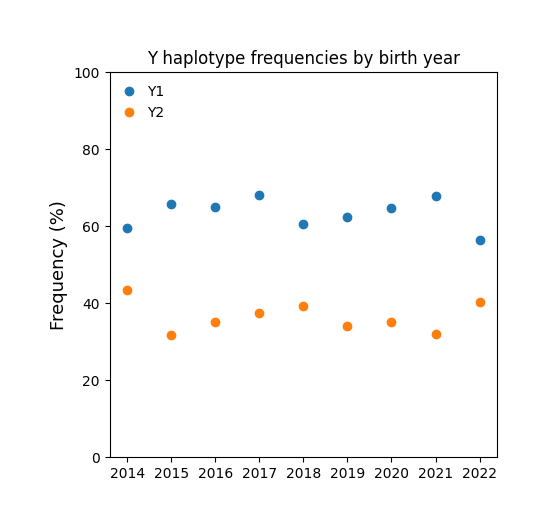

In [6]:
# Figure 1C
plot_births_over_time('Y')

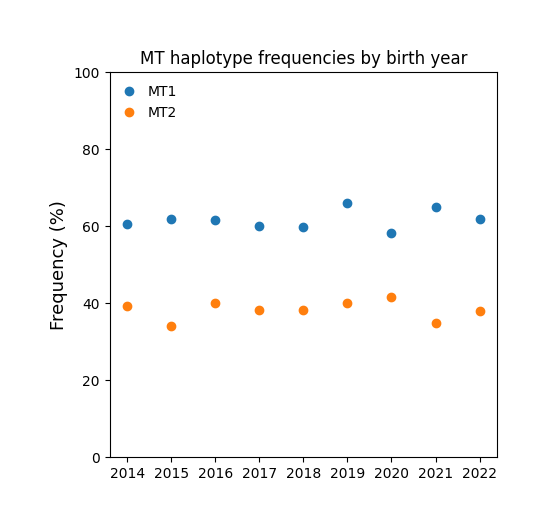

In [7]:
# Figure 2C
plot_births_over_time('MT')

Plot distribution of heterozygosity by haplotype and sequencing method. This is
*Figure S1*

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Setting missing calls to np.nan
Filtering out 300 variants for INFO score < 0.5
Genotypes for 7483 rats across 4927 variants
Read 117 variants across 15120 samples
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Genotypes for 15120 rats across 117 variants


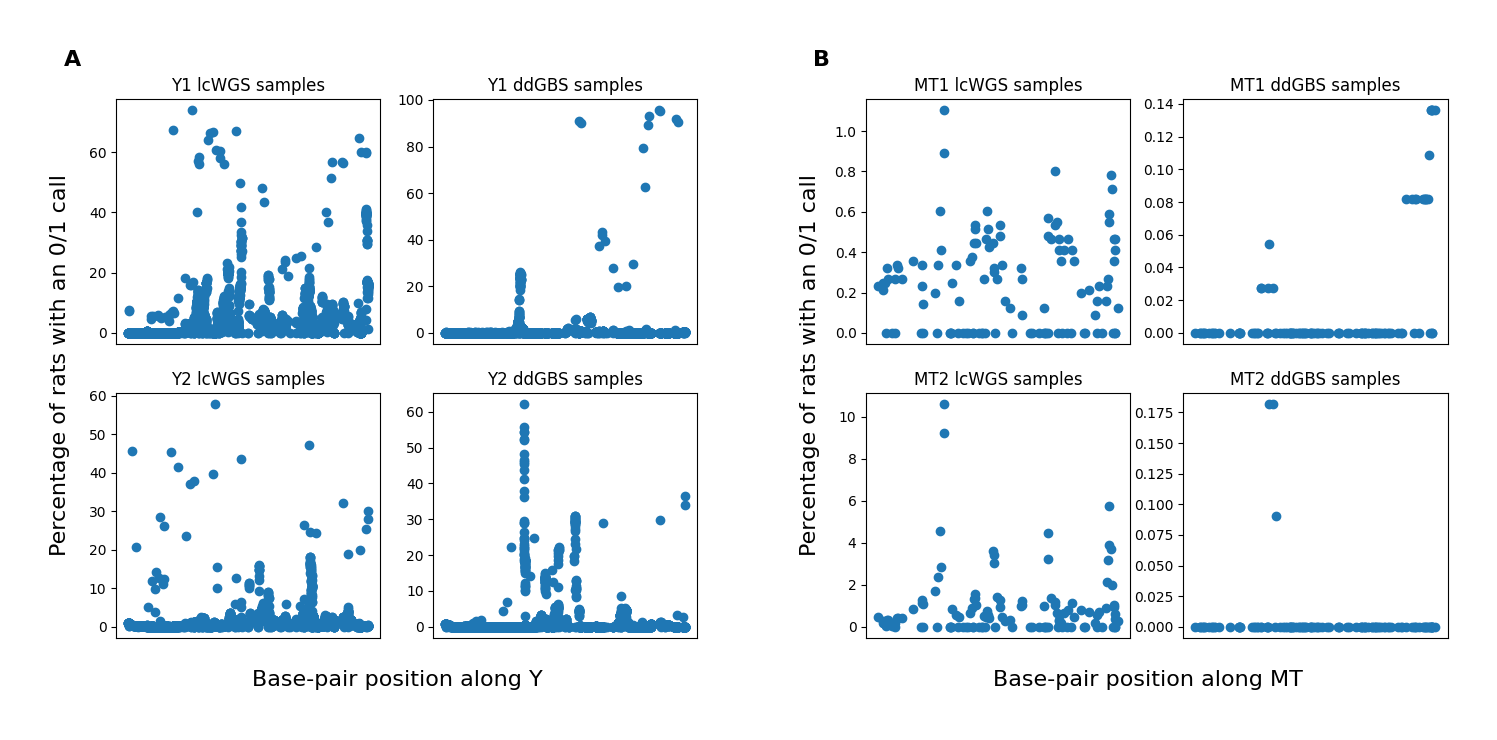

In [8]:
(fig1, fig2) = plt.figure(figsize=(15, 7)).subfigures(nrows=1, ncols=2)
plot_het_distribution(fig1, 'Y', tag='A')
plot_het_distribution(fig2, 'MT', tag='B')
io_helpers.save_plot('heterozygosity', extension='png')

Check if PheWAS has well-powered size/haplotype frequency. This is *Figure S3*.

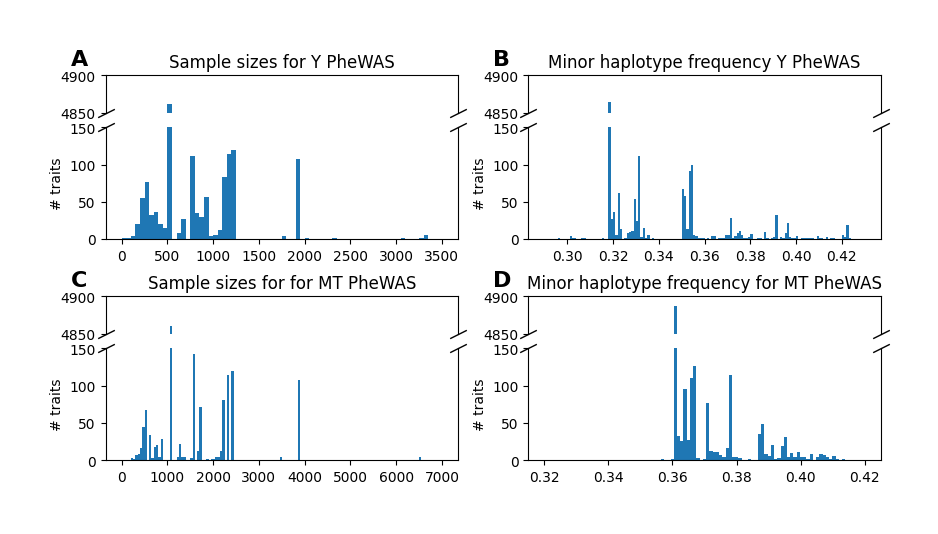

In [9]:
# extra middle row provides padding for plot titles
fig, axs = plt.subplots(nrows=5, ncols=2, height_ratios=[1, 3, 0.75, 1, 3])
fig.subplots_adjust(hspace=0.225)
axs[2, 0].set_visible(False)
axs[2, 1].set_visible(False)

rfids_with_y_group = sample_info.index[sample_info['Y_group'].notna()]
y_sample_sizes = pheno.filter(rfids_with_y_group, axis='index').notna().sum()
broken_axes_histogram(y_sample_sizes, binwidth=50, xmin=0, xmax=3500, 
                      top_ax=axs[0, 0], bottom_ax=axs[1, 0],
                      title='Sample sizes for Y PheWAS', tag='A')

y_freqs = pheno.apply(minor_haplo_freq, chrom='Y').dropna()
broken_axes_histogram(y_freqs, binwidth=0.001, xmin=0.29, xmax=0.43, 
                      top_ax=axs[0, 1], bottom_ax=axs[1, 1],
                      title='Minor haplotype frequency Y PheWAS', tag='B')

rfids_with_mt_group = sample_info.index[sample_info['MT_group'].notna()]
mt_sample_sizes = pheno.filter(rfids_with_mt_group, axis='index').notna().sum()
broken_axes_histogram(mt_sample_sizes, binwidth=50, xmin=0, xmax=7000, 
                      top_ax=axs[3, 0], bottom_ax=axs[4, 0],
                      title='Sample sizes for for MT PheWAS', tag='C')

mt_freqs = pheno.apply(minor_haplo_freq, chrom='MT').dropna()
broken_axes_histogram(mt_freqs, binwidth=0.001, xmin=0.32, xmax=0.42, 
                      top_ax=axs[3, 1], bottom_ax=axs[4, 1],
                      title='Minor haplotype frequency for MT PheWAS', tag='D')

fig.set_size_inches(10, 5)
io_helpers.save_plot('PheWAS_hist', extension='png', figure=fig)

In [10]:
print(f'Mean Y sample size is {round(y_sample_sizes.mean())}, '
      f'Mean MT sample size is {round(mt_sample_sizes.mean())}')

Mean Y sample size is 593, Mean MT sample size is 1212


Make PCA biplots. This is *Figure S8*.

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 300 variants for INFO score < 0.5
Filtering out 217 variants for MAF=0
Filtering out 578 variants for % nonmissing calls < 75
Filtering out 12 samples for % nonmissing calls < 50
Genotypes for 7471 rats across 4132 variants
Read 18499 variants across 8 samples
0 samples removed for not being male
14367 variants removed for not being in the given subset
Setting heterozygous calls to missing
Setting missing calls to np.nan
Genotypes for 8 rats across 4132 variants
Read 117 variants across 15120 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Filtering out 40 variants for MAF=0
Filtering out 0 variants for % nonmissing calls < 75
Filtering out 149 samples for % nonmissing calls < 50
Genotypes for 14971 rats across 77 variants
Read 122 variants across 8

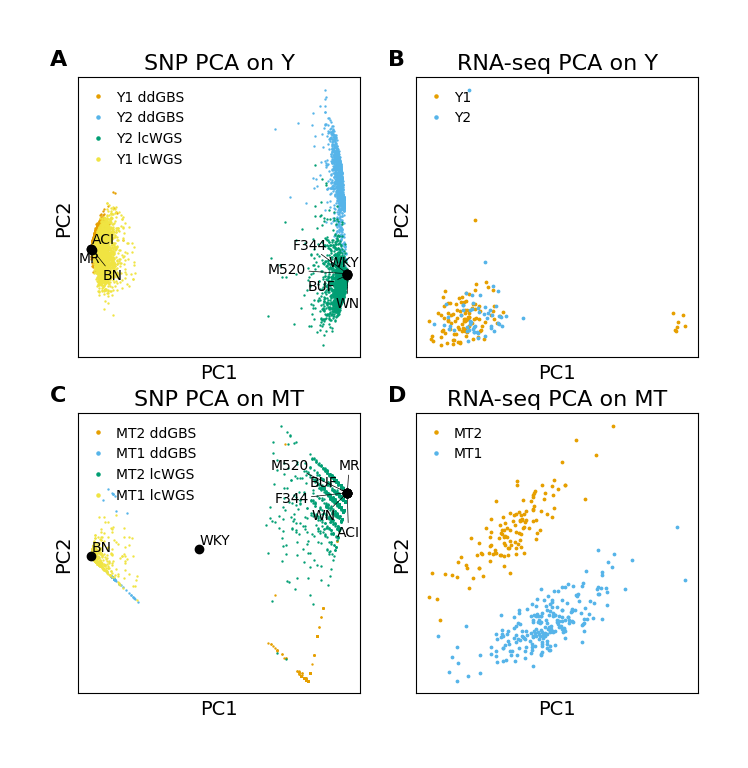

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

genotype_pca(axs[0, 0], 'Y', tag='A')
rnaseq_pca(axs[0, 1], 'Y', tag='B')
genotype_pca(axs[1, 0], 'MT', tag='C')
rnaseq_pca(axs[1, 1], 'MT', tag='D')

io_helpers.save_plot('PCA', extension='png', figure=fig)

Load MT genotypes with absolutely no filters applied.

In [12]:
mt_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'MT', format='allele_num', 
    
    use_maf_filter=False, use_miss_filter=False
    )
is_missing = mt_modern.isnull()
no_maf = genotype_helpers.are_variants_maf_0(mt_modern)

Read 117 variants across 15120 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Genotypes for 15120 rats across 117 variants


In [13]:
mt_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'MT', format='nucleotide',
    
    use_maf_filter=False, use_miss_filter=False
)

Read 122 variants across 8 samples
Genotypes for 8 rats across 122 variants


Determine restriction sites.

In [14]:
ref_mt = ''
ref_mt_file = io_helpers.file_path('data', 'genotypes', 'mRatBN_7_2_MT.fasta')
with open(ref_mt_file) as fasta:
    # skip sample information line
    fasta.readline()
    for line in fasta: ref_mt += line.strip()

In [15]:
# string -> list of characters conversion
mt1_seq = list(ref_mt)
mt2_seq = list(ref_mt)

# update MT1 and MT2 sequences with variants present in founder strains
for pos in mt_founders.columns:
    # VCF is 1-indexed, Python lists are 0-indexed
    mt1_seq[pos - 1] = mt_founders.loc['BN', pos]
    mt2_seq[pos - 1] = mt_founders.loc['BUF', pos]

# list of characters -> string conversion
mt1_seq = ''.join(mt1_seq)
mt2_seq = ''.join(mt2_seq)

[Gileta *et al.* 2020](https://doi.org/10.1534/g3.120.401325) has the 
recognition sequences for the restriction enzymes used.

In [16]:
print('Neither MT1 nor MT2 has PstI restrction sites (CTGCAG): '
      f'MT1 has none = {not list(re.finditer("CTGCAG", mt1_seq))}, '
      f'MT2 has none = {not list(re.finditer("CTGCAG", mt1_seq))}')
mt1_cuts = [m.end() for m in re.finditer('CATG', mt1_seq)]
mt2_cuts = [m.end() for m in re.finditer('CATG', mt2_seq)]

Neither MT1 nor MT2 has PstI restrction sites (CTGCAG): MT1 has none = True, MT2 has none = True


Plot MT missingness by haplotype and sequencing method. This is *Figure S10*.

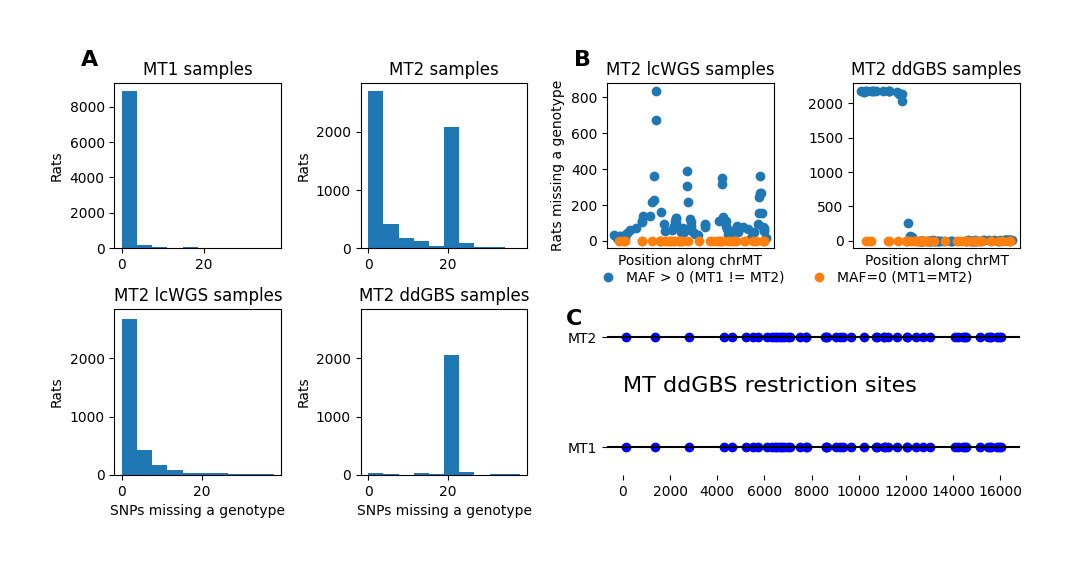

In [17]:
fig, axs = plt.subplot_mosaic([
    ['MT1', 'MT2', 'lcWGS_dots', 'ddGBS_dots'],
    ['lcWGS_hist', 'ddGBS_hist', 'res_cut', 'res_cut']
    ])

for haplo in ['MT1', 'MT2']: 
    rfids = sample_info.loc[sample_info['MT_group'] == haplo].index
    na_count_hist(mt_modern.loc[rfids], haplo, axs[haplo])

# tracking down the missingness in MT2
for method in seq_methods:
    rfids = sample_info.loc[(sample_info['MT_group'] == 'MT2')
                           & (sample_info['seq_method'] == method)].index

    hist_ax = f'{method}_hist'
    na_count_hist(mt_modern.loc[rfids], f'MT2 {method}', axs[hist_ax])
    axs[hist_ax].set_xlabel('SNPs missing a genotype')
    # use the same scale as the MT2 method-combined histogram, for context
    axs[hist_ax].sharex(axs['MT2'])
    axs[hist_ax].sharey(axs['MT2'])

    dot_ax = f'{method}_dots'
    # plot MAF>0 dots, then MAF=0
    axs[dot_ax].scatter(mt_modern.columns[~no_maf],
                        is_missing.loc[rfids, ~no_maf].sum(axis=0),
                        label='MAF > 0 (MT1 != MT2)')
    axs[dot_ax].scatter(mt_modern.columns[no_maf], 
                        is_missing.loc[rfids, no_maf].sum(axis=0),
                        label='MAF=0 (MT1=MT2)')
    
    axs[dot_ax].set_title(f'MT2 {method} samples')
    axs[dot_ax].set_xticks([])
    axs[dot_ax].set_xlabel('Position along chrMT')

# restriction cut sites
axs['res_cut'].axhline(y=1, color='black')
axs['res_cut'].scatter(x=mt1_cuts, y=[1]*len(mt1_cuts), color='blue')
axs['res_cut'].axhline(y=2, color='black')
axs['res_cut'].scatter(x=mt2_cuts, y=[2]*len(mt2_cuts), color='blue')

for border in ['top', 'bottom', 'left', 'right']: 
    axs['res_cut'].spines[border].set_visible(False)
axs['res_cut'].set_ylim(0.75, 2.25)
axs['res_cut'].set_yticks(ticks=[1, 2], labels=['MT1', 'MT2'])
axs['res_cut'].text(0, 1.5, 'MT ddGBS restriction sites', fontsize=16)

io_helpers.write_panel_tag('A', x=-0.2, y=1.2, ax=axs['MT1'])
io_helpers.write_panel_tag('B', x=-0.2, y=1.2, ax=axs['lcWGS_dots'])
io_helpers.write_panel_tag('C', x=-0.1, y=1, ax=axs['res_cut'])

axs['lcWGS_dots'].set_ylabel('Rats missing a genotype')

fig.set_size_inches(10, 5)
fig.tight_layout()
# legend goes below plot
axs['ddGBS_dots'].legend(bbox_to_anchor=(0.75, -0.1), ncol=2,
                         loc='upper right', borderaxespad=0)

io_helpers.save_plot('MT_missing', extension='png', figure=fig)